# 🎯 Customer Segmentation Using K-Means (Unsupervised Learning)

**Industry-Grade Customer Behavior Analysis with Transactional Data**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RansiluRanasinghe/Customer-Segmentation-K-Means/blob/main/notebook.ipynb)

---

## 📌 Project Overview

This notebook implements an **end-to-end, production-aligned unsupervised machine learning pipeline** for customer segmentation using **K-Means clustering**.

The project simulates how machine learning engineers and data science teams analyze large-scale retail transaction data to discover meaningful customer segments **without labeled data**. The focus is on **data validation, feature engineering, model robustness, and business interpretability**, rather than on predictive accuracy.

---

## 🎯 What This Notebook Does

Using real-world online retail transaction data, the pipeline:

1. ✅ **Cleans and validates** raw transactional records
2. ✅ **Aggregates data** at the customer level
3. ✅ **Engineers RFM** (Recency, Frequency, Monetary) behavioral features
4. ✅ **Applies K-Means clustering** to identify natural customer groups
5. ✅ **Evaluates clusters** using industry-appropriate unsupervised metrics
6. ✅ **Interprets results** from a business and operational perspective

---

## 💡 Design Philosophy

This notebook reflects **industry best practices** for unsupervised modeling and is designed to be:
- 📊 **Reproducible** — Clear, sequential workflow
- 🔍 **Interpretable** — Business-focused insights
- 🔧 **Extendable** — Ready for real-world customer analytics use cases

---

**Author:** Ransilu Ranasinghe  
**GitHub:** [RansiluRanasinghe](https://github.com/RansiluRanasinghe)  
**LinkedIn:** [ransilu-ranasinghe](https://www.linkedin.com/in/ransilu-ranasinghe-a596792ba)

---

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [2]:
plt.style.use("seaborn-v0_8-darkgrid")

import warnings
warnings.filterwarnings("ignore")

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

####Loading the data

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mashlyn/online-retail-ii-uci")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'online-retail-ii-uci' dataset.
Path to dataset files: /kaggle/input/online-retail-ii-uci


In [5]:
import os

DATASET_PATH = "/kaggle/input/online-retail-ii-uci"

os.listdir(DATASET_PATH)

['online_retail_II.csv']

In [6]:
df = pd.read_csv(os.path.join(DATASET_PATH, "online_retail_II.csv"), encoding="ISO-8859-1")

display(df.head(5))

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [7]:
print("Dataset shape:", df.shape)
print("Column names:", list(df.columns))
print("\nDatatypes: \n\n", df.dtypes)

Dataset shape: (1067371, 8)
Column names: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

Datatypes: 

 Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object


####Dataset Analysis

In [8]:
column_mapping = {
    "Invoice" : "InvoiceNO",
    "Price" : "UnitPrice",
    "Customer ID" : "CustomerID"
}

df = df.rename(columns=column_mapping)

display(df.head(5))

,InvoiceNO,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [9]:
required_columns = ["InvoiceNO", "Quantity", "UnitPrice", "InvoiceDate", "CustomerID"]
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
  raise ValueError(f"Missing required columns: {missing_columns}")

In [10]:
print("Record count: ", len(df))
print("\n Missing values per column: ")
print(df.isna().sum())

Record count:  1067371

 Missing values per column: 
InvoiceNO           0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     243007
Country             0
dtype: int64


In [11]:
print("Checking Bussiness rule violations: ")

print("Negative quantities: ", (df["Quantity"] <= 0).sum())
print("Negative prices: ", (df["UnitPrice"] <= 0).sum())

print("Missing customer ID ", df["Quantity"].isnull().sum())

Checking Bussiness rule violations: 
Negative quantities:  22950
Negative prices:  6207
Missing customer ID  0


In [12]:
cancellations = df[df["InvoiceNO"].astype(str).str.startswith("C")]
print("Cancellations: ", len(cancellations))

Cancellations:  19494


In [13]:
print("Unique Products: ", df["StockCode"].nunique())
print("Unique Customers: ", df["CustomerID"].nunique())
print("Countries represented: ", df["Country"].nunique())

Unique Products:  5305
Unique Customers:  5942
Countries represented:  43


####Data Cleaning

In [14]:
df_clean = df.copy()

In [15]:
df_clean["InvoiceDate"] = pd.to_datetime(df_clean["InvoiceDate"])

In [16]:
df_clean = df_clean[~df_clean['InvoiceNO'].astype(str).str.startswith('C', na=False)]

In [17]:
df_clean = df_clean[df_clean['Quantity'] > 0]
df_clean = df_clean[df_clean['UnitPrice'] > 0]

In [18]:
initial_count = len(df_clean)

df_clean = df_clean.dropna(subset=['CustomerID'])
removed_count = initial_count - len(df_clean)
print(f"Removed {removed_count} rows with missing CustomerID.")

Removed 236121 rows with missing CustomerID.


In [19]:
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

In [20]:
initial_count = len(df)

df_clean = df_clean.drop_duplicates()
removed_count = initial_count - len(df_clean)
print(f"Removed {removed_count} duplicate rows.")

Removed 287946 duplicate rows.


In [21]:
df_clean["TotalValue"] = df_clean["Quantity"] * df_clean["UnitPrice"]

In [22]:
print(f"\nDate range: {df_clean['InvoiceDate'].min()} to {df_clean['InvoiceDate'].max()}")
print(f"Cleaned dataset shape: {df_clean.shape}")


Date range: 2009-12-01 07:45:00 to 2011-12-09 12:50:00
Cleaned dataset shape: (779425, 9)


####Explotary Data Analysis(EDA)

In [23]:
print("Transaction Statics: \n")

print("Average Quantity: ", df_clean["Quantity"].mean())
print("Mediun Quantity: ", df_clean["Quantity"].median())
print("95th percentile quantity: ", df_clean["Quantity"].quantile(0.95), "\n")

print("Average UnitPrice: ", df_clean["UnitPrice"].mean())
print("Mediun UnitPrice: ", df_clean["UnitPrice"].median())
print("95th percentile UnitPrice: ", df_clean["UnitPrice"].quantile(0.95), "\n")

print("Average Transaction value: ", df_clean["TotalValue"].mean())
print("Mediun Transaction value: ", df_clean["TotalValue"].median())
print("95th percentile Transaction value: ", df_clean["TotalValue"].quantile(0.95), "\n")

Transaction Statics: 

Average Quantity:  13.489369727683869
Mediun Quantity:  6.0
95th percentile quantity:  36.0 

Average UnitPrice:  3.2184879853738333
Mediun UnitPrice:  1.95
95th percentile UnitPrice:  8.5 

Average Transaction value:  22.29182316194631
Mediun Transaction value:  12.48
95th percentile Transaction value:  67.5 



In [24]:
customer_stats = df_clean.groupby("CustomerID").agg({
    "InvoiceNO": "nunique",
    "TotalValue": "sum"
}).rename(columns={'InvoiceNO': 'TransactionCount', 'TotalValue': 'TotalSpend'})

In [25]:
print("Customer Level Statistics: \n")

print("Total Customers: ", len(customer_stats))

print("Average Transactions per customer: ", customer_stats["TransactionCount"].mean())
print("Mediun Transactions per customer: ", customer_stats["TransactionCount"].median(), "\n")

print("Average Spend per customer: ", customer_stats["TotalSpend"].mean())
print("Mediun Spend per customer: ", customer_stats["TotalSpend"].median(), "\n")

Customer Level Statistics: 

Total Customers:  5878
Average Transactions per customer:  6.289384144266758
Mediun Transactions per customer:  3.0 

Average Spend per customer:  2955.9040945899965
Mediun Spend per customer:  867.74 



In [26]:
top_20_percent_customers = int(len(customer_stats) * 0.2)
top_customers = customer_stats.nlargest(top_20_percent_customers, 'TotalSpend')
top_customers_share = top_customers['TotalSpend'].sum() / customer_stats['TotalSpend'].sum()

print("Pareto Analysis: \n")
print(f"Top 20% customers represent {top_customers_share:.1%} of total revenue.")

Pareto Analysis: 

Top 20% customers represent 77.2% of total revenue.


In [27]:
print("Outlier assesment with Unique IQR: \n")

for column in ['Quantity', 'UnitPrice', 'TotalValue']:
  Q1 = df_clean[column].quantile(0.25)
  Q3 = df_clean[column].quantile(0.75)

  IQR = Q3 -Q1

  upper_bound = Q3 + 1.5 * IQR

  outliers = df_clean[df_clean[column] > upper_bound]
  print(f"{column}: {len(outliers):,} outliers ({len(outliers)/len(df_clean):.1%} of transactions)")

Outlier assesment with Unique IQR: 

Quantity: 51,119 outliers (6.6% of transactions)
UnitPrice: 65,463 outliers (8.4% of transactions)
TotalValue: 63,562 outliers (8.2% of transactions)


####Feature Engineering - RFM Modeling

In [28]:
ref_date = df_clean["InvoiceDate"].max() + pd.Timedelta(days=1)

In [29]:
rfm_data = df_clean.groupby("CustomerID").agg({
    "InvoiceDate" : lambda x: (ref_date - x.max()).days,
    "InvoiceNO" : "nunique",
    "TotalValue" : "sum"
}).rename(columns={
    "InvoiceDate" : "Recency",
    "InvoiceNO" : "Frequency",
    "TotalValue" : "Monetary"
})

In [30]:
print("RFM Data Statistics: \n")

print(rfm_data.describe())

RFM Data Statistics: 

           Recency    Frequency       Monetary
count  5878.000000  5878.000000    5878.000000
mean    201.331916     6.289384    2955.904095
std     209.338707    13.009406   14440.852688
min       1.000000     1.000000       2.950000
25%      26.000000     1.000000     342.280000
50%      96.000000     3.000000     867.740000
75%     380.000000     7.000000    2248.305000
max     739.000000   398.000000  580987.040000


In [31]:
print("Customers with zero frquency", (rfm_data["Frequency"] == 0).sum())
print("Customers with zero monetary", (rfm_data["Monetary"] == 0).sum())

Customers with zero frquency 0
Customers with zero monetary 0


In [32]:
rfm_data = rfm_data[(rfm_data["Frequency"] > 0) & (rfm_data["Monetary"] > 0)]

print("Final RFM dataset shape: ", rfm_data.shape)

Final RFM dataset shape:  (5878, 3)


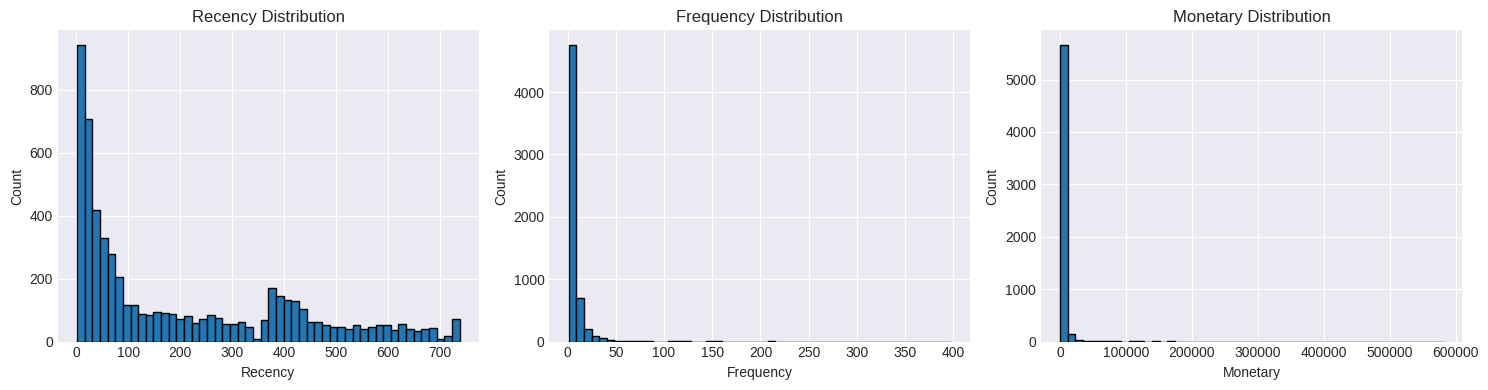

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, (col, ax) in enumerate(zip(['Recency', 'Frequency', 'Monetary'], axes)):
    ax.hist(rfm_data[col], bins=50, edgecolor='black')
    ax.set_title(f'{col} Distribution')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
plt.tight_layout()
plt.savefig("rfm_distributions.png", dpi=300)
plt.show()

####Data Transformation & Scaling

In [34]:
rfm_transformed = rfm_data.copy()

In [35]:
rfm_transformed["Frequency_log"] = np.log1p(rfm_transformed["Frequency"])
rfm_transformed["Monetary_log"] = np.log1p(rfm_transformed["Monetary"])

In [36]:
rfm_transformed["Recency_raw"] = rfm_transformed["Recency"]

In [37]:
print("Post Transformation Statistics: \n")

print(rfm_transformed[["Frequency_log", "Monetary_log", "Recency_raw"]].describe())

Post Transformation Statistics: 

       Frequency_log  Monetary_log  Recency_raw
count    5878.000000   5878.000000  5878.000000
mean        1.549588      6.816979   201.331916
std         0.809447      1.385486   209.338707
min         0.693147      1.373716     1.000000
25%         0.693147      5.838546    26.000000
50%         1.386294      6.767044    96.000000
75%         2.079442      7.718377   380.000000
max         5.988961     13.272485   739.000000


####Scaling the features

In [38]:
scaler = StandardScaler()

features_to_scale = ["Recency_raw", "Frequency_log", "Monetary_log"]
rfm_scaled = scaler.fit_transform(rfm_transformed[features_to_scale])

In [39]:
rfm_scaled_df = pd.DataFrame(rfm_scaled,
                            columns=[f'{col}_scaled' for col in features_to_scale],
                            index=rfm_transformed.index)

In [40]:
print("Scaled Features statistics: \n")

print(rfm_scaled_df.describe())

Scaled Features statistics: 

       Recency_raw_scaled  Frequency_log_scaled  Monetary_log_scaled
count        5.878000e+03          5.878000e+03         5.878000e+03
mean        -4.230860e-17          1.885755e-16         3.771510e-16
std          1.000085e+00          1.000085e+00         1.000085e+00
min         -9.570564e-01         -1.058146e+00        -3.929108e+00
25%         -8.376226e-01         -1.058146e+00        -7.062613e-01
50%         -5.032078e-01         -2.017514e-01        -3.604460e-02
75%          8.535607e-01          6.546432e-01         6.506556e-01
max          2.568631e+00          5.484918e+00         4.659776e+00


In [41]:
print("Missing Values in scaled dataframe: ", rfm_scaled_df.isnull().sum().sum())
print("\nInfinite values in the dataset: \n", np.isinf(rfm_scaled_df).sum())

Missing Values in scaled dataframe:  0

Infinite values in the dataset: 
 Recency_raw_scaled      0
Frequency_log_scaled    0
Monetary_log_scaled     0
dtype: int64


####Model Selection

In [42]:
k_range = range(2, 11)

inertias = []
silhouette_scores = []
davies_bouldin_scores = []

In [43]:
for k in k_range:
  kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)
  cluster_labels = kmeans.fit_predict(rfm_scaled_df)

  inertias.append(kmeans.inertia_)
  silhouette_scores.append(silhouette_score(rfm_scaled_df, cluster_labels))
  davies_bouldin_scores.append(davies_bouldin_score(rfm_scaled_df, cluster_labels))

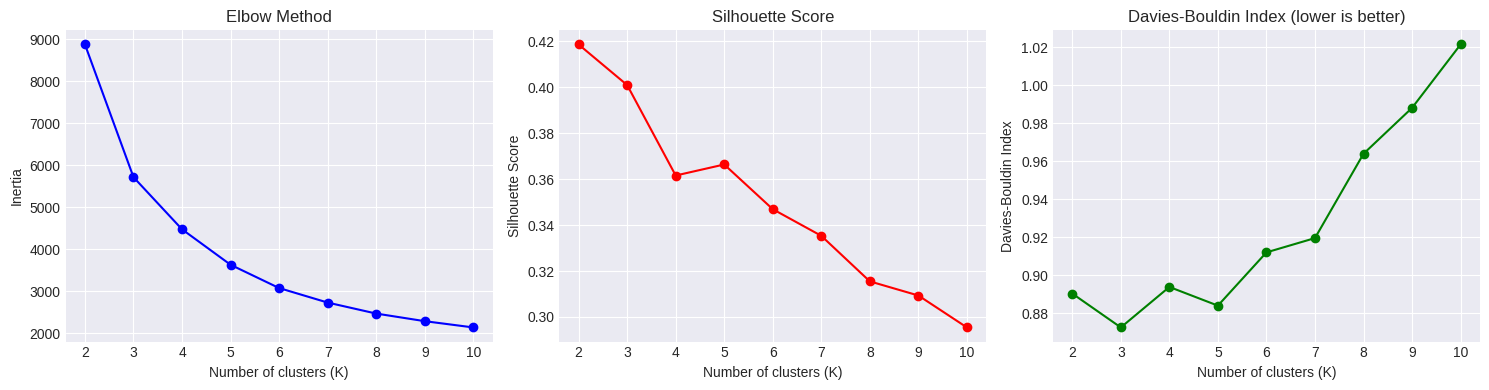

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Number of clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True)

axes[1].plot(k_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score')
axes[1].grid(True)

axes[2].plot(k_range, davies_bouldin_scores, 'go-')
axes[2].set_xlabel('Number of clusters (K)')
axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin Index (lower is better)')
axes[2].grid(True)

plt.tight_layout()
plt.savefig("Plot elbow method_K Evaluation")
plt.show()

In [45]:
print("Cluster Evaluation Metrics: \n")

for k, inertia, sil, db in zip(k_range, inertias, silhouette_scores, davies_bouldin_scores):
  print(f"K={k}: Inertia={inertia:,.0f}, Silhouette={sil:.3f}, DB={db:.3f}")

Cluster Evaluation Metrics: 

K=2: Inertia=8,881, Silhouette=0.419, DB=0.890
K=3: Inertia=5,716, Silhouette=0.401, DB=0.873
K=4: Inertia=4,473, Silhouette=0.362, DB=0.894
K=5: Inertia=3,628, Silhouette=0.366, DB=0.884
K=6: Inertia=3,072, Silhouette=0.347, DB=0.912
K=7: Inertia=2,726, Silhouette=0.335, DB=0.920
K=8: Inertia=2,464, Silhouette=0.316, DB=0.964
K=9: Inertia=2,283, Silhouette=0.309, DB=0.988
K=10: Inertia=2,133, Silhouette=0.295, DB=1.021


In [46]:
SELECTED_K = 3
print(f"Selected K: {SELECTED_K}", "Choose based on Stability and Interpretability")

Selected K: 3 Choose based on Stability and Interpretability


In [47]:
print("Stability Analysis: \n")

stability_results = []
for run in range(5):
  kmeans_test = KMeans(n_clusters=SELECTED_K, random_state=run, n_init=10)
  labels_test = kmeans_test.fit_predict(rfm_scaled_df)
  stability_results.append(labels_test)
  print(f"Run {run + 1}: {labels_test}")

print("\nStability Results: \n", stability_results)

Stability Analysis: 

Run 1: [1 1 0 ... 2 2 1]
Run 2: [1 1 0 ... 2 2 1]
Run 3: [0 0 2 ... 1 1 0]
Run 4: [2 2 0 ... 1 1 2]
Run 5: [2 2 0 ... 1 1 2]

Stability Results: 
 [array([1, 1, 0, ..., 2, 2, 1], dtype=int32), array([1, 1, 0, ..., 2, 2, 1], dtype=int32), array([0, 0, 2, ..., 1, 1, 0], dtype=int32), array([2, 2, 0, ..., 1, 1, 2], dtype=int32), array([2, 2, 0, ..., 1, 1, 2], dtype=int32)]


In [48]:
from collections import Counter

label_counts = Counter(stability_results[0])
print("Cluster size in first run: ", dict(label_counts))

Cluster size in first run:  {np.int32(1): 1675, np.int32(0): 2363, np.int32(2): 1840}


####Final Model Training

In [49]:
final_kmeans = KMeans(n_clusters=SELECTED_K, random_state=RANDOM_SEED, n_init=20)
rfm_scaled_df["Cluster"] = final_kmeans.fit_predict(rfm_scaled_df)

In [50]:
rfm_transformed["Cluster"] = rfm_scaled_df["Cluster"]

In [51]:
print("Final Model Trained Sucessfully\n")
print("Inertia : ", final_kmeans.inertia_)
print("Number of iterations: ", final_kmeans.n_iter_)

Final Model Trained Sucessfully

Inertia :  5716.039021099992
Number of iterations:  11


####Validation and Qality Assesment

In [52]:
silhouette_avg = silhouette_score(rfm_scaled_df.drop("Cluster", axis=1), rfm_scaled_df["Cluster"])

db_index = davies_bouldin_score(rfm_scaled_df.drop("Cluster", axis=1), rfm_scaled_df["Cluster"])

print("Silhoutte Score: ", silhouette_avg)
print("Davies-Bouldin Index: ", db_index)

Silhoutte Score:  0.4009982034076402
Davies-Bouldin Index:  0.8726219304270336


In [53]:
print("Cluster Centroids: \n")

centroides_scaled = final_kmeans.cluster_centers_
for i, centroid in enumerate(centroides_scaled):
  print(f"  Cluster {i}: R={centroid[0]:.2f}, F={centroid[1]:.2f}, M={centroid[2]:.2f}")

Cluster Centroids: 

  Cluster 0: R=1.30, F=-0.74, M=-0.73
  Cluster 1: R=-0.69, F=1.27, M=1.17
  Cluster 2: R=-0.52, F=-0.32, M=-0.26


In [54]:
print("Cluster Centroids: \n")

for cluster in range(SELECTED_K):
  cluster_data = rfm_transformed[rfm_transformed["Cluster"] == cluster]
  r_avg = cluster_data["Recency"].mean()
  f_avg = np.expm1(cluster_data["Frequency_log"]).mean()
  m_avg = np.expm1(cluster_data["Monetary_log"]).mean()
  print(f"  Cluster {cluster}: Recency={r_avg:.0f} days, " f"Frequency={f_avg:.1f} transactions, " f"Monetary=${m_avg:.0f}")

Cluster Centroids: 

  Cluster 0: Recency=473 days, Frequency=1.8 transactions, Monetary=$555
  Cluster 1: Recency=57 days, Frequency=16.0 transactions, Monetary=$8562
  Cluster 2: Recency=92 days, Frequency=2.9 transactions, Monetary=$851


####Cluster Interpretation and Profiling

In [55]:
cluster_profiles = []

In [56]:
for cluster in range(SELECTED_K):
  cluster_mask = rfm_transformed["Cluster"] == cluster
  cluster_data = rfm_transformed[cluster_mask]

  profile = {
    "Cluster" : cluster,
    "Size" : len(cluster_data),
    "Size_Percentage" : len(cluster_data) / len(rfm_transformed) * 100,
    "Recency_Avg" : cluster_data["Recency"].mean(),
    "Frequency_Avg" : np.expm1(cluster_data["Frequency_log"]).mean(),
    "Monetary_Avg" : np.expm1(cluster_data["Monetary_log"]).mean(),
    "Recency_Median" : cluster_data["Recency"].median(),
    "Frequency_Median" : np.expm1(cluster_data["Frequency_log"]).median(),
    "Monetary_Median" : np.expm1(cluster_data["Monetary_log"]).median(),
}

  cluster_profiles.append(profile)

In [57]:
profiles_df = pd.DataFrame(cluster_profiles)

display(profiles_df)

,Cluster,Size,Size_Percentage,Recency_Avg,Frequency_Avg,Monetary_Avg,Recency_Median,Frequency_Median,Monetary_Median
0,0,1840,31.303164,472.945652,1.788587,555.300958,438.0,1.0,326.45
1,1,1675,28.496087,57.290746,15.953433,8561.950574,25.0,11.0,3939.24
2,2,2363,40.200749,91.936945,2.943716,851.368301,61.0,3.0,716.54


In [58]:
profiles_df = profiles_df.sort_values(by="Monetary_Avg", ascending=False)

display(profiles_df)

,Cluster,Size,Size_Percentage,Recency_Avg,Frequency_Avg,Monetary_Avg,Recency_Median,Frequency_Median,Monetary_Median
1,1,1675,28.496087,57.290746,15.953433,8561.950574,25.0,11.0,3939.24
2,2,2363,40.200749,91.936945,2.943716,851.368301,61.0,3.0,716.54
0,0,1840,31.303164,472.945652,1.788587,555.300958,438.0,1.0,326.45


In [59]:
for idx, row in profiles_df.iterrows():
  print(f"\nCLUSTER {int(row['Cluster'])}:")
  print(f"  Size: {int(row['Size']):,} customers ({row['Size_Percentage']:.1f}%)")
  print(f"  Recency: {row['Recency_Avg']:.0f} days since last purchase")
  print(f"  Frequency: {row['Frequency_Avg']:.1f} transactions")
  print(f"  Monetary: ${row['Monetary_Avg']:.0f} total spend")
  print(f"  Median values: R={row['Recency_Median']:.0f}d, "f"F={row['Frequency_Median']:.1f}, M=${row['Monetary_Median']:.0f}")


CLUSTER 1:
  Size: 1,675 customers (28.5%)
  Recency: 57 days since last purchase
  Frequency: 16.0 transactions
  Monetary: $8562 total spend
  Median values: R=25d, F=11.0, M=$3939

CLUSTER 2:
  Size: 2,363 customers (40.2%)
  Recency: 92 days since last purchase
  Frequency: 2.9 transactions
  Monetary: $851 total spend
  Median values: R=61d, F=3.0, M=$717

CLUSTER 0:
  Size: 1,840 customers (31.3%)
  Recency: 473 days since last purchase
  Frequency: 1.8 transactions
  Monetary: $555 total spend
  Median values: R=438d, F=1.0, M=$326


####Assigned Business Personas

In [60]:
persona_mapping = {}

In [61]:
sorted_by_r = profiles_df.sort_values("Recency_Avg")
sorted_by_m = profiles_df.sort_values("Monetary_Avg", ascending=False)

In [62]:
for cluster in range(SELECTED_K):
  cluster_profiles = profiles_df[profiles_df["Cluster"] == cluster].iloc[0]

  recency_mask = sorted_by_r[sorted_by_r["Cluster"] == cluster].index[0] + 1
  monetory_mask = sorted_by_m[sorted_by_m["Cluster"] == cluster].index[0] + 1

  if monetory_mask == 1 and recency_mask <= 2:
    persona = "High value loyal customers"
    action = "Retention and Premium Offers"

  elif monetory_mask <=2 and recency_mask <= 2:
    persona = "Recent active customers"
    action = "Upsell and crosse sell opportunities"

  elif recency_mask == SELECTED_K:
    persona = "At-risk customers"
    action = "Win back campaigns"

  else:
    persona = "Occasional Buyers"
    action = "Re-engagement and awareness"

  persona_mapping[cluster] = {'persona': persona, 'action': action}

  print("Cluster ", cluster, " ",persona)
  print("Business action: ", action)
  print(f"\n  Key Stats: R={cluster_profiles['Recency_Avg']:.0f}d, "
          f"F={cluster_profiles['Frequency_Avg']:.1f}, "
          f"M=${cluster_profiles['Monetary_Avg']:.0f}")

Cluster  0   High value loyal customers
Business action:  Retention and Premium Offers

  Key Stats: R=473d, F=1.8, M=$555
Cluster  1   Recent active customers
Business action:  Upsell and crosse sell opportunities

  Key Stats: R=57d, F=16.0, M=$8562
Cluster  2   At-risk customers
Business action:  Win back campaigns

  Key Stats: R=92d, F=2.9, M=$851


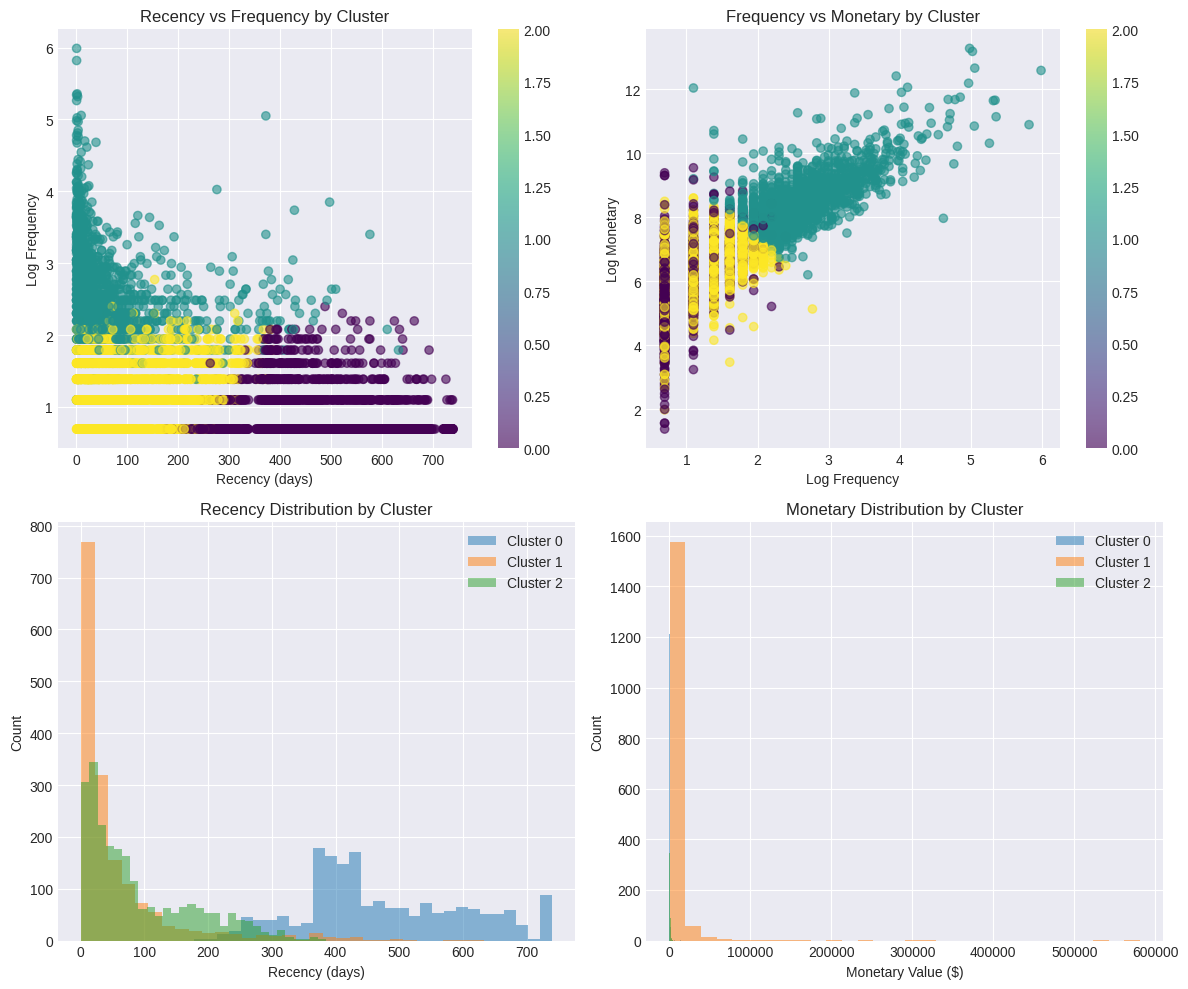

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

cluster_means = rfm_transformed.groupby('Cluster')[['Recency', 'Frequency_log', 'Monetary_log']].mean()

scatter = axes[0, 0].scatter(rfm_transformed['Recency'],
                            rfm_transformed['Frequency_log'],
                            c=rfm_transformed['Cluster'],
                            cmap='viridis', alpha=0.6)
axes[0, 0].set_xlabel('Recency (days)')
axes[0, 0].set_ylabel('Log Frequency')
axes[0, 0].set_title('Recency vs Frequency by Cluster')
plt.colorbar(scatter, ax=axes[0, 0])

scatter = axes[0, 1].scatter(rfm_transformed['Frequency_log'],
                            rfm_transformed['Monetary_log'],
                            c=rfm_transformed['Cluster'],
                            cmap='viridis', alpha=0.6)
axes[0, 1].set_xlabel('Log Frequency')
axes[0, 1].set_ylabel('Log Monetary')
axes[0, 1].set_title('Frequency vs Monetary by Cluster')
plt.colorbar(scatter, ax=axes[0, 1])

for cluster in range(SELECTED_K):
    cluster_data = rfm_transformed[rfm_transformed['Cluster'] == cluster]['Recency']
    axes[1, 0].hist(cluster_data, bins=30, alpha=0.5, label=f'Cluster {cluster}')
axes[1, 0].set_xlabel('Recency (days)')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Recency Distribution by Cluster')
axes[1, 0].legend()

for cluster in range(SELECTED_K):
    cluster_data = np.expm1(rfm_transformed[rfm_transformed['Cluster'] == cluster]['Monetary_log'])
    axes[1, 1].hist(cluster_data, bins=30, alpha=0.5, label=f'Cluster {cluster}')
axes[1, 1].set_xlabel('Monetary Value ($)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Monetary Distribution by Cluster')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig("RFM Cluster Behavior Overview.png")
plt.show()

####Saving Final Results

In [65]:
final_results = rfm_transformed[["Recency", "Frequency_log", "Monetary_log", "Cluster"]].copy()
final_results["Frequency"] = np.expm1(final_results["Frequency_log"])
final_results["Monetary"] = np.expm1(final_results["Monetary_log"])
final_results = final_results[['Recency', 'Frequency', 'Monetary', 'Cluster']]

In [67]:
final_results["Persona"] = final_results["Cluster"].map(
    {k: v["persona"] for k, v in persona_mapping.items()}
)

In [69]:
final_results["Recommended_Action"] = final_results["Cluster"].map(
    {k: v["action"] for k, v in persona_mapping.items()}
)

In [70]:
display(final_results.head())

,Recency,Frequency,Monetary,Cluster,Persona,Recommended_Action
CustomerID,,,,,,
12346,326,12.0,77556.46,1,Recent active customers,Upsell and crosse sell opportunities
12347,2,8.0,4921.53,1,Recent active customers,Upsell and crosse sell opportunities
12348,75,5.0,2019.40,2,At-risk customers,Win back campaigns
12349,19,4.0,4428.69,1,Recent active customers,Upsell and crosse sell opportunities
12350,310,1.0,334.40,0,High value loyal customers,Retention and Premium Offers


In [71]:
print(f"Final segmented customers: {len(final_results):,}")

Final segmented customers: 5,878
